In [125]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [98]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
# First, we get the data
dataset = pd.read_csv('C:/Users/kth25/ai_dataset/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [23]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values #첫 번째 열(['High'])만 선택
test_set = dataset['2017':].iloc[:,1:2].values
print(training_set)

[[ 82.55]
 [ 82.5 ]
 [ 82.9 ]
 ...
 [167.74]
 [166.99]
 [166.7 ]]


### < Pandas DataFrame에서 특정 행/열을 선택하는 방법 >



1. 행번호(row number)로 선택하는 방법 (.iloc)
: 행이든 열이든 숫자로 location을 나타내서 Selecting or Indexing을 하는 방법

```
data.iloc[0:5] # 첫 5개행만
data.iloc[:, 0:2] # 첫 2개열만
data.iloc[[0,3,6,24], [0,5,6]] # 1st, 4th, 7th, 25th 행과 + 1st 6th 7th 열만
data.iloc[0:5, 5:8] # 첫 5개 행과 5th, 6th, 7th 열만
```


2. label이나 조건표현으로 선택하는 방법 (.loc)

```
data.loc['Andrade']  # Andrade 행만 선택, series를 반환
data.loc[['Andrade','Veness']] # Andrade와 Veness 둘다 선택, dataframe을 반환
data.loc[['Andreade','Veness'],['first_name', 'address', 'city']] #행과 열 동시에 label로 선택
data.loc[['Andrade', 'Veness'], 'city':'email'] #연속되는 label의 경우 예시
```

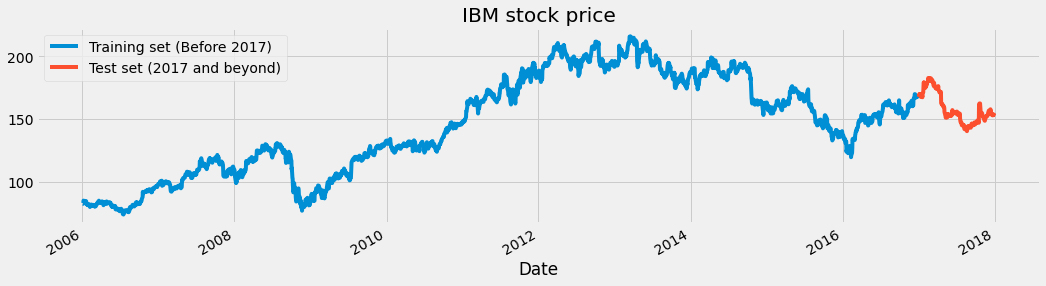

In [7]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [137]:
# 0과 1사이 값으로 스케일링!!
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

#스케일링 해서 무슨 일이 일어났는지 확인 작업
compare = np.c_[training_set, training_set_scaled]
print(compare)

[[8.25500000e+01 6.06508876e-02]
 [8.25000000e+01 6.02986757e-02]
 [8.29000000e+01 6.31163708e-02]
 ...
 [1.67740000e+02 6.60749507e-01]
 [1.66990000e+02 6.55466329e-01]
 [1.66700000e+02 6.53423500e-01]]


LSTM은 train data를 생성하는 과정이 특이하군!!

> *0~59번째를 X_train의 첫 번째 data로 넣고, 그에 대응되는 y_train의 값이 60번째 data!*

> *1~60번째를 X_train의 두 번째 data로 넣고, 그에 대응되는 y_train의 값이 61번재 data!*

이런식으로 생성..... 왕 신기방기

In [46]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train)
print(y_train)

[[0.06065089 0.06029868 0.06311637 ... 0.0656523  0.06656805 0.06769513]
 [0.06029868 0.06311637 0.0781206  ... 0.06656805 0.06769513 0.06875176]
 [0.06311637 0.0781206  0.07262609 ... 0.06769513 0.06875176 0.06804734]
 ...
 [0.594745   0.59587208 0.59094111 ... 0.66420118 0.65898845 0.66244012]
 [0.59587208 0.59094111 0.58812342 ... 0.65898845 0.66244012 0.66074951]
 [0.59094111 0.58812342 0.59002536 ... 0.66244012 0.66074951 0.65546633]]
[0.06875176 0.06804734 0.06797689 ... 0.66074951 0.65546633 0.6534235 ]


In [47]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train)

[[[0.06065089]
  [0.06029868]
  [0.06311637]
  ...
  [0.0656523 ]
  [0.06656805]
  [0.06769513]]

 [[0.06029868]
  [0.06311637]
  [0.0781206 ]
  ...
  [0.06656805]
  [0.06769513]
  [0.06875176]]

 [[0.06311637]
  [0.0781206 ]
  [0.07262609]
  ...
  [0.06769513]
  [0.06875176]
  [0.06804734]]

 ...

 [[0.594745  ]
  [0.59587208]
  [0.59094111]
  ...
  [0.66420118]
  [0.65898845]
  [0.66244012]]

 [[0.59587208]
  [0.59094111]
  [0.58812342]
  ...
  [0.65898845]
  [0.66244012]
  [0.66074951]]

 [[0.59094111]
  [0.58812342]
  [0.59002536]
  ...
  [0.66244012]
  [0.66074951]
  [0.65546633]]]


In [16]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 49s 102ms/step - loss: 0.0482
Epoch 2/50
85/85 [==============================] - 9s 100ms/step - loss: 0.0104
Epoch 3/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0076
Epoch 4/50
85/85 [==============================] - 9s 107ms/step - loss: 0.0068
Epoch 5/50
85/85 [==============================] - 9s 109ms/step - loss: 0.0067
Epoch 6/50
85/85 [==============================] - 9s 108ms/step - loss: 0.0057
Epoch 7/50
85/85 [==============================] - 9s 108ms/step - loss: 0.0045
Epoch 8/50
85/85 [==============================] - 12s 136ms/step - loss: 0.0047
Epoch 9/50
85/85 [==============================] - 13s 149ms/step - loss: 0.0049
Epoch 10/50
85/85 [==============================] - 12s 142ms/step - loss: 0.0041
Epoch 11/50
85/85 [==============================] - 13s 149ms/step - loss: 0.0036
Epoch 12/50
85/85 [==============================] - 11s 127ms/step - loss: 0.0035
Epoch 13/50
85/85 [

In [48]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)

# test_set시작보다 60 전부터!! data 가공을 위해서!!
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
print(inputs)

[[0.58812342]
 [0.59002536]
 [0.59559031]
 [0.58474218]
 [0.57079459]
 [0.56551141]
 [0.57473936]
 [0.57727529]
 [0.54282897]
 [0.55304311]
 [0.55621302]
 [0.5438856 ]
 [0.54649197]
 [0.54395604]
 [0.55649479]
 [0.56438433]
 [0.56706114]
 [0.56628628]
 [0.5633277 ]
 [0.55931248]
 [0.56213018]
 [0.56142575]
 [0.57882502]
 [0.57755706]
 [0.57495069]
 [0.61439842]
 [0.61566638]
 [0.61932939]
 [0.6002395 ]
 [0.6030572 ]
 [0.60573401]
 [0.61129896]
 [0.62735982]
 [0.62735982]
 [0.62299239]
 [0.62869822]
 [0.63905325]
 [0.63729219]
 [0.63299521]
 [0.62172443]
 [0.60826994]
 [0.61432798]
 [0.61179205]
 [0.64271626]
 [0.64849253]
 [0.65356438]
 [0.65405748]
 [0.67631727]
 [0.67589462]
 [0.67561285]
 [0.67040011]
 [0.65736827]
 [0.66434207]
 [0.66215835]
 [0.66420118]
 [0.65898845]
 [0.66244012]
 [0.66074951]
 [0.65546633]
 [0.6534235 ]
 [0.66166526]
 [0.67575373]
 [0.6723725 ]
 [0.67610595]
 [0.67526064]
 [0.66321499]
 [0.66089039]
 [0.66265145]
 [0.66596224]
 [0.66384897]
 [0.66673711]
 [0.65

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

train data로 학습시켰으니까 train data에 대한 prediction과 실제 값 비교해보면 error가 적다는 걸 확인해보고 싶었는뎅...
data 가공하면서 60개가 약간 밀렸나...? 삭제된 건가...?

-> train data에 대한 결과는 61번째 값부터 나오겠지? so 그래프 그려보면 real 값보다 60만큼 값이 빨리 나와..!!

In [52]:
predicted_train_dataset = regressor.predict(X_train)
predicted_train_dataset = sc.inverse_transform(predicted_train_dataset)

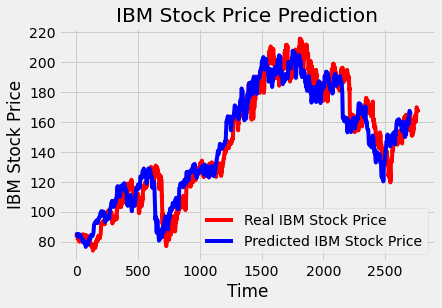

In [54]:
plot_predictions(training_set,predicted_train_dataset)

return_rmse(training_set,predicted_train_dataset) - data 개수가 달라서 오류!!

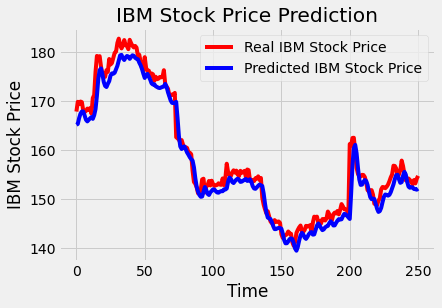

In [27]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [56]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.4928494273370303.


Truth be told. That's one awesome score.

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have Gated Recurrent Units(GRU). It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

In [127]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 30s 358ms/step - loss: 0.1116
Epoch 2/50
19/19 [==============================] - 7s 373ms/step - loss: 0.0410
Epoch 3/50
19/19 [==============================] - 7s 351ms/step - loss: 0.0153
Epoch 4/50
19/19 [==============================] - 7s 383ms/step - loss: 0.0049
Epoch 5/50
19/19 [==============================] - 7s 387ms/step - loss: 0.0047
Epoch 6/50
19/19 [==============================] - 7s 378ms/step - loss: 0.0041
Epoch 7/50
19/19 [==============================] - 6s 302ms/step - loss: 0.0039
Epoch 8/50
19/19 [==============================] - 6s 330ms/step - loss: 0.0036
Epoch 9/50
19/19 [==============================] - 6s 336ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 6s 338ms/step - loss: 0.0035
Epoch 11/50
19/19 [==============================] - 6s 299ms/step - loss: 0.0031
Epoch 12/50
19/19 [==============================] - 6s 305ms/step - loss: 0.0032
Epoch 13/50
19/19 [=====

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [128]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

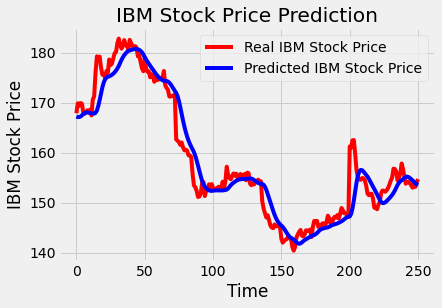

In [129]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [130]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.27183548534022.


Sequence Generation

Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation. The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.

In [131]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

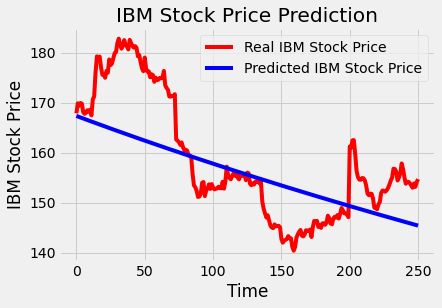

In [132]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [133]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 8.831944114404124.


So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. Applying both LSTM and GRU together gave even better results.